In [1]:
import numpy as np
import time as time
import matplotlib.pyplot as plt
from feature_extraction import OCR_raw_data, OCR_feature_data, face_raw_data, face_feature_data

Perceptron Model for OCR and Face Detection

In [17]:
class Perceptron:
    def __init__(self, input_size, output_size):
        self.weights = np.zeros((output_size, input_size))
        self.bias = np.zeros(output_size)
        self.model = None
    def train(self, X, y):
            correctTrain = 0
            for i in range(X.shape[0]):
                # Forward pass
                weighted_sum = np.dot(self.weights,X[i]) + self.bias
                if len(weighted_sum) == 2:
                    prediction = 1 if weighted_sum[1] > 0.5 else 0
                else:
                    prediction = np.argmax(weighted_sum)
                if y[i] != prediction:
                    self.weights[prediction, :] -= X[i]
                    self.bias[prediction] -= 1
                    self.weights[y[i], :] += X[i]
                    self.bias[y[i]] += 1
                else:
                     correctTrain += 1
            acc = correctTrain / X.shape[0]
            self.model = (self.weights, self.bias)
            return acc, self.model
            
    
    def predict(self, X):
        predictions = []
        for i in range(X.shape[0]):
            weighted_sum = np.dot(self.weights, X[i]) + self.bias
            if len(weighted_sum) == 2:
                    prediction = 1 if weighted_sum[1] > 0.5 else 0
            else:
                prediction = np.argmax(weighted_sum)
            predictions.append(prediction)
        return predictions

Select Training Data Helper Function

In [18]:
def process_data(xTrain, yTrain, n):
    num_rows = xTrain.shape[0]
    num_select =  int(num_rows*n)
    selected_indices = np.random.choice(num_rows, num_select, replace=False)
    x = [xTrain[index] for index in selected_indices]
    y = [yTrain[index] for index in selected_indices]
    xTrain = np.array(x)
    yTrain = np.array(y)
    return xTrain, yTrain

In [38]:
# Initialize and train Custom Perceptron for OCR
def OnePerceptronSet(n, input_size, output_size, epochs,X_tr,Y_tr, X_v,Y_v, X_te,Y_te):
    import time as time
    X, Y = process_data(X_tr, Y_tr,n)
    ocr_perceptron = Perceptron(input_size, output_size)
    accuracy =[]
    validAcc = []
    models = []
    max = 0
    maxCount = 0
    start_time = time.time()
    for i in range(epochs):
        trainAcc, model = ocr_perceptron.train(X, Y)
        models.append(model)
        # Predict and evaluate
        vali_predictions = ocr_perceptron.predict(X_v)
        test_predictions = ocr_perceptron.predict(X_te)

        CorrectPredictionCount = 0
        for j in range(len(vali_predictions)):
            if vali_predictions[j] == Y_v[j]:
                CorrectPredictionCount += 1
        vali_Ocr_Accuracy = CorrectPredictionCount/len(vali_predictions)
        validAcc.append(vali_Ocr_Accuracy)
        if  validAcc[i] > max :
            max = validAcc[i]
            maxCount = 0
        else:
            maxCount += 1
        if maxCount == 3:
            break
        CorrectPredictionCount = 0
        for k in range(len(test_predictions)):
            if test_predictions[k] == Y_te[k]:
                CorrectPredictionCount += 1
        test_Ocr_Accuracy = CorrectPredictionCount/len(test_predictions)
        print(f'Epoch {i+1}/{epochs} - Training Accuracy: {trainAcc*100:.2f}% - Validation Accuracy: {vali_Ocr_Accuracy*100:.2f}% - Test Accuracy: {test_Ocr_Accuracy*100:.2f}%')
        accuracy.append(test_Ocr_Accuracy)
    end_time = time.time()
    elasped_time = end_time - start_time
    best_model = models[np.argmax(validAcc)]
    """
    for i in range(20):
        test_predictions = ocr_perceptron.predict(X_te)
        CorrectPredictionCount = 0
        for i in range(len(test_predictions)):
            if test_predictions[i] == Y_te[i]:
                CorrectPredictionCount += 1
        Ocr_Accuracy = CorrectPredictionCount/len(test_predictions)
        print(f'Test Accuracy: {Ocr_Accuracy*100:.2f}%')
        accuracy.append(Ocr_Accuracy)
    """
    mean_accuracy = np.mean(accuracy)*100
    std_accuracy = np.std(accuracy)*100
    print(f'Time taken: {elasped_time:.2f} seconds')
    print(f'Average OCR Accuracy: {mean_accuracy:.2f}%')
    print(f'Standard Deviation OCR Accuracy: {std_accuracy:.2f}%')
    return mean_accuracy, std_accuracy, elasped_time, best_model




In [20]:
training_sets = [0.1, 0.2, 0.3,0.4, 0.5, 0.6, 0.7, 0.8,0.9, 1.0]

OCR

In [6]:
OCRtrainImg = "digitdata/trainingimages"
OCRtrainLabel = "digitdata/traininglabels"

OCRvalidImg = "digitdata/validationimages"
OCRvalidLabel = "digitdata/validationlabels"

OCRtestImg = "digitdata/testimages"
OCRtestLabel = "digitdata/testlabels"

X_train_Ocr, Y_train_Ocr = OCR_raw_data(OCRtrainImg, OCRtrainLabel)
X_valid_Ocr, Y_valid_Ocr = OCR_raw_data(OCRvalidImg, OCRvalidLabel)
X_test_Ocr, Y_test_Ocr = OCR_raw_data(OCRtestImg, OCRtestLabel)

print(X_train_Ocr.shape)
print(len(Y_train_Ocr))
print(X_valid_Ocr.shape)
print(len(Y_valid_Ocr))
print(X_test_Ocr.shape)
print(len(Y_test_Ocr))


(5000, 784)
5000
(1000, 784)
1000
(1000, 784)
1000


Training set size: 10%
Epoch 1/10 - Training Accuracy: 50.40% - Validation Accuracy: 64.10% - Test Accuracy: 58.60%
Epoch 2/10 - Training Accuracy: 82.00% - Validation Accuracy: 60.80% - Test Accuracy: 54.60%
Epoch 3/10 - Training Accuracy: 88.60% - Validation Accuracy: 70.00% - Test Accuracy: 65.80%
Epoch 4/10 - Training Accuracy: 92.20% - Validation Accuracy: 71.00% - Test Accuracy: 68.70%
Epoch 5/10 - Training Accuracy: 95.20% - Validation Accuracy: 69.40% - Test Accuracy: 66.20%
Epoch 6/10 - Training Accuracy: 95.60% - Validation Accuracy: 73.00% - Test Accuracy: 65.70%
Epoch 7/10 - Training Accuracy: 94.80% - Validation Accuracy: 74.20% - Test Accuracy: 69.10%
Epoch 8/10 - Training Accuracy: 96.60% - Validation Accuracy: 77.50% - Test Accuracy: 70.80%
Epoch 9/10 - Training Accuracy: 99.40% - Validation Accuracy: 76.50% - Test Accuracy: 70.60%
Epoch 10/10 - Training Accuracy: 98.60% - Validation Accuracy: 74.30% - Test Accuracy: 70.10%
Time taken: 0.26 seconds
Average OCR Accuracy:

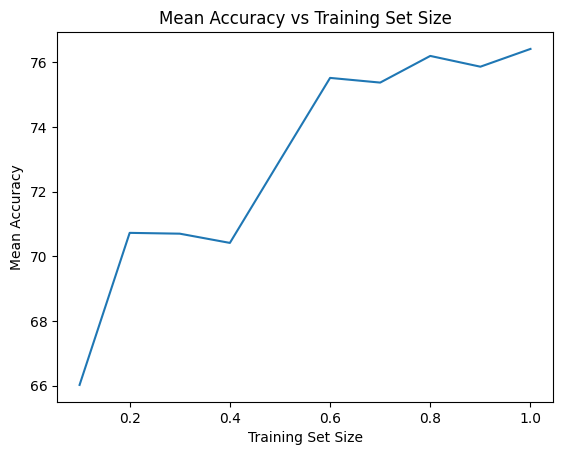

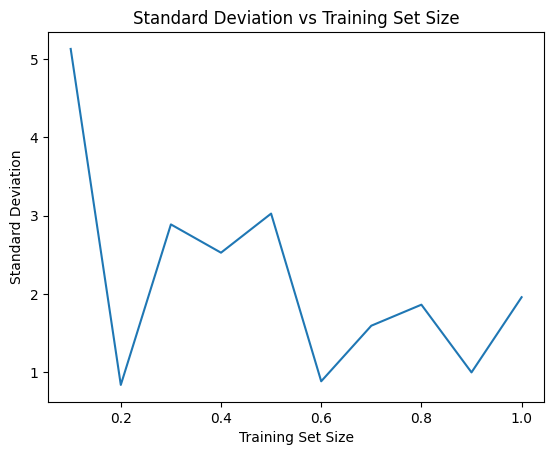

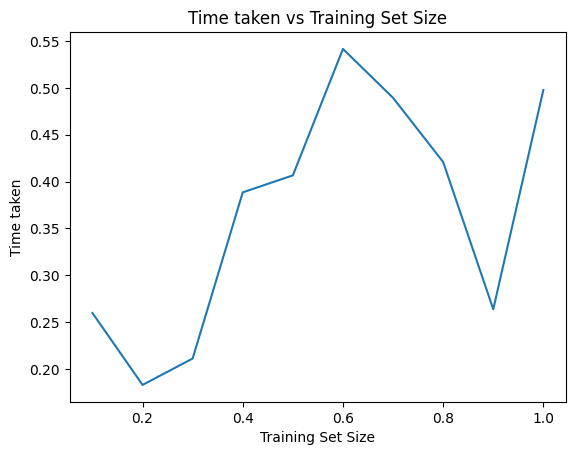

In [33]:
timesOcrArr = []
meanAccOcrArr = []
stdAccOcrArr = []
for i in training_sets:
    print(f'Training set size: {i*100:.0f}%')
    mean,std,time,bestModel=OnePerceptronSet(i, 784, 10, 10, X_train_Ocr, Y_train_Ocr, X_valid_Ocr, Y_valid_Ocr, X_test_Ocr, Y_test_Ocr)
    timesOcrArr.append(time)
    meanAccOcrArr.append(mean)
    stdAccOcrArr.append(std)
    print("")
plt.plot(training_sets, meanAccOcrArr)
plt.xlabel('Training Set Size')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs Training Set Size')
plt.show()

plt.plot(training_sets, stdAccOcrArr)
plt.xlabel('Training Set Size')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation vs Training Set Size')
plt.show()

plt.plot(training_sets, timesOcrArr)
plt.xlabel('Training Set Size')
plt.ylabel('Time taken')
plt.title('Time taken vs Training Set Size')
plt.show()

Face Detection

In [34]:
FacetrainImg = "facedata/facedatatrain"
FacetrainLabel = "facedata/facedatatrainlabels"

FacevalidImg = "facedata/facedatavalidation"
FacevalidLabel = "facedata/facedatavalidationlabels"

FacetestImg = "facedata/facedatatest"
FacetestLabel = "facedata/facedatatestlabels"

X_train_face, Y_train_face = face_raw_data(FacetrainImg, FacetrainLabel)


X_valid_face, Y_valid_face = face_raw_data(FacevalidImg, FacevalidLabel)


X_test_face, Y_test_face = face_raw_data(FacetestImg, FacetestLabel)

print(X_train_face.shape)
print(len(Y_train_face))
print(X_valid_face.shape)
print(len(Y_valid_face))
print(X_test_face.shape)
print(len(Y_test_face))

(451, 4200)
451
(301, 4200)
301
(150, 4200)
150


Training set size: 10%
Epoch 1/10 - Training Accuracy: 57.78% - Validation Accuracy: 67.77% - Test Accuracy: 72.00%
Epoch 2/10 - Training Accuracy: 91.11% - Validation Accuracy: 68.44% - Test Accuracy: 72.67%
Epoch 3/10 - Training Accuracy: 95.56% - Validation Accuracy: 69.44% - Test Accuracy: 74.67%
Epoch 4/10 - Training Accuracy: 100.00% - Validation Accuracy: 69.44% - Test Accuracy: 74.67%
Epoch 5/10 - Training Accuracy: 100.00% - Validation Accuracy: 69.44% - Test Accuracy: 74.67%
Time taken: 0.04 seconds
Average OCR Accuracy: 73.73%
Standard Deviation OCR Accuracy: 1.16%

Training set size: 20%
Epoch 1/10 - Training Accuracy: 64.44% - Validation Accuracy: 74.09% - Test Accuracy: 73.33%
Epoch 2/10 - Training Accuracy: 92.22% - Validation Accuracy: 62.13% - Test Accuracy: 62.67%
Epoch 3/10 - Training Accuracy: 95.56% - Validation Accuracy: 61.46% - Test Accuracy: 62.00%
Epoch 4/10 - Training Accuracy: 94.44% - Validation Accuracy: 77.41% - Test Accuracy: 75.33%
Epoch 5/10 - Training

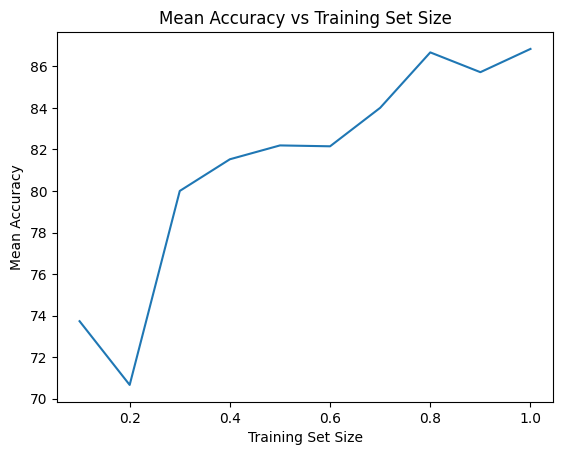

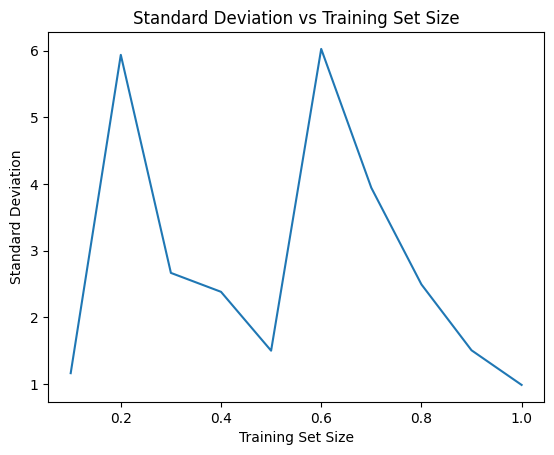

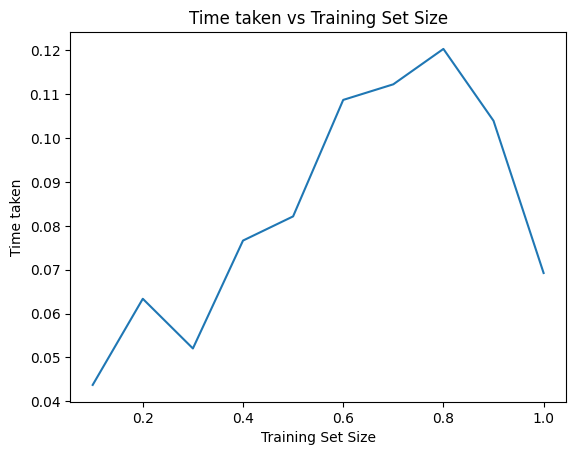

In [39]:
timesFaceArr = []
meanAccFaceArr = []
stdAccFaceArr = []
for i in training_sets:
    print(f'Training set size: {i*100:.0f}%')
    mean,std,time, model=OnePerceptronSet(i, 70*60, 2, 10, X_train_face, Y_train_face, X_valid_face, Y_valid_face, X_test_face, Y_test_face)
    timesFaceArr.append(time)
    meanAccFaceArr.append(mean)
    stdAccFaceArr.append(std)
    print("")
plt.plot(training_sets, meanAccFaceArr)
plt.xlabel('Training Set Size')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs Training Set Size')
plt.show()

plt.plot(training_sets, stdAccFaceArr)
plt.xlabel('Training Set Size')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation vs Training Set Size')
plt.show()

plt.plot(training_sets, timesFaceArr)
plt.xlabel('Training Set Size')
plt.ylabel('Time taken')
plt.title('Time taken vs Training Set Size')
plt.show()



In [18]:
face_perceptron = Perceptron(input_size=70*60, output_size=2)
face_perceptron.train(X_train_face, Y_train_face, 10)

face_predictions = face_perceptron.predict(X_valid_face)

CorrectPredictionCount = 0
for i in range(len(face_predictions)):
    if face_predictions[i] == Y_valid_face[i]:
        CorrectPredictionCount += 1
Face_Accuracy = CorrectPredictionCount/len(face_predictions)
print(f'Face Accuracy: {Face_Accuracy * 100:.2f}%')

[ 2. -2.]
0
[ 106. -106.]
0
[ 90. -90.]
0
[-32.  32.]
1
[ 26. -26.]
0
[-40.  40.]
1
[ 143. -143.]
0
[ 68. -68.]
0
[ 79. -79.]
0
[ 88. -88.]
0
[ 14. -14.]
0
[ 53. -53.]
0
[ 78. -78.]
0
[-3.  3.]
1
[ 61. -61.]
0
[ 128. -128.]
0
[-36.  36.]
1
[-38.  38.]
1
[ 47. -47.]
0
[ 71. -71.]
0
[ 55. -55.]
0
[-15.  15.]
1
[ 9. -9.]
0
[ 14. -14.]
0
[ 15. -15.]
0
[ 160. -160.]
0
[ 97. -97.]
0
[ 76. -76.]
0
[ 91. -91.]
0
[ 57. -57.]
0
Face Accuracy: 70.00%
